## 1. Implement GMM method using EM algorithm (70 points)
### should return $\pi_k$, $\mu_k$, $\Sigma_k$

In [1]:
import numpy as np
import scipy.io
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
class GaussianMixtureModel:
    def __init__(self, k, max_iterations=1000, TOL = 1e-3):
        self.k = k
        self.max_iterations = max_iterations
        self.TOL = TOL
    
    def fit(self, X):

        #--------------------Initialize the parameters and implement E and M steps--------------------------
       
        n, m = X.shape

        #Initialize parameters
        self.mu = np.random.randn(self.k, m)
        self.sigma = np.zeros((self.k, m, m))
        for i in range(self.k):
            self.sigma[i] = np.eye(m)
        self.pi = np.ones(self.k) / self.k
        
        mus=[]
        pis=[]
        sigmas=[]        
        log_list=[np.inf]
        for ite in range(1,self.max_iterations+1):
            #print(ite)
            
            # ----------------------------------------E step----------------------------------------------------

            posterior = np.zeros((n, self.k))
        
            for i in range(self.k):
                #print(pi[i])
                posterior[:, i] = self.pi[i] * multivariate_normal.pdf(X, mean=self.mu[i], cov=self.sigma[i])          
            posterior /= posterior.sum(axis=1, keepdims=True)
            #print(posterior.shape)
     
            # ---------------------------------------M steps--------------------------------------------------
            # Update pi, mu, sigma
        
            self.pi = posterior.mean(axis = 0)
        
            for i in range(self.k):
                self.mu[i] = (posterior[:, i]@X) / (posterior.sum(axis = 0)[i])
                #print((mu[i]).shape)
                diff = X - self.mu[i]
                self.sigma[i] =  (posterior[:, i]*diff.T @ diff )/ (posterior.sum(axis = 0)[i])
                
            
            Nu = np.zeros((n, self.k))
            for i in range(self.k):
                #print(pi[i])
                Nu[:, i] = self.pi[i] * multivariate_normal.pdf(X, mean=self.mu[i], cov=self.sigma[i])  
            
            log_like = np.sum(np.log(Nu.sum(axis=1)))

            pis.append(self.pi)
            mus.append(self.mu)
            sigmas.append(self.sigma)
            log_list.append(log_like)
            # ---------------------------------------Plotting--------------------------------------------------

            res = self.predict(X)
            df = pd.DataFrame(X)
            df['label']=res
            plt.figure()
            sns.scatterplot(data=df, x=df.iloc[:,0], y=df.iloc[:,1], hue="label")
            for i in range(self.k):
                m = self.mu[i]  # defining the mean of the Gaussian (mX = 0.2, mY=0.6)
                cov = self.sigma[i]   # defining the covariance matrix
                cov_inv = np.linalg.inv(cov)  # inverse of covariance matrix
                cov_det = np.linalg.det(cov)  # determinant of covariance matrix
                # Plotting
                xi = np.linspace(-8, 8)
                yi = np.linspace(-8, 8)
                Xi,Yi = np.meshgrid(xi,yi)
                coe = 1.0 / ((2 * np.pi)**2 * cov_det)**0.5
                Zi = coe * np.e ** (-0.5 * (cov_inv[0,0]*(Xi-m[0])**2 + (cov_inv[0,1] + cov_inv[1,0])*(Xi-m[0])*(Yi-m[1]) + cov_inv[1,1]*(Yi-m[1])**2))
                plt.contour(Xi,Yi,Zi)
                plt.title(f'iteration:{ite}')
                plt.show                
            
            if abs(log_like-log_list[-2])<=self.TOL:
                break 
            
        log_list=log_list[1:]
        
        return self.pi, self.mu, self.sigma, log_list, ite
    
    
    def predict(self, X):
        # Find the cluster probabilities
        probabilities = np.zeros((X.shape[0], self.k))
        for i in range(self.k):
            probabilities[:, i] = self.pi[i] * multivariate_normal.pdf(X, mean=self.mu[i], cov=self.sigma[i])          

        return np.argmax(probabilities, axis=1) # Return the labels

## 2. Load X.mat, and estimate parameters: $\pi_k$, $\mu_k$, $\Sigma_k$ (10 points)


In [3]:
mat = scipy.io.loadmat('X.mat')
X = mat['X']

In [4]:
X.shape

(1800, 2)

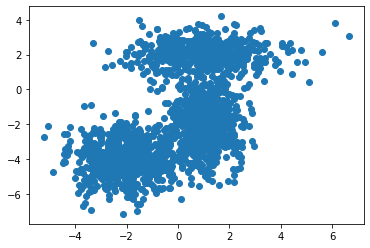

In [5]:
plt.scatter(X[:,0],X[:,1])

In [6]:
X

array([[ 1.9562784 ,  2.09485882],
       [ 0.92421992,  2.53823803],
       [ 2.83124931,  2.34614454],
       ...,
       [ 1.6629174 , -2.1940192 ],
       [ 0.46182328, -0.69517086],
       [ 1.69431476, -2.81776129]])

C:\Users\User\anaconda3\envs\dlenv\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


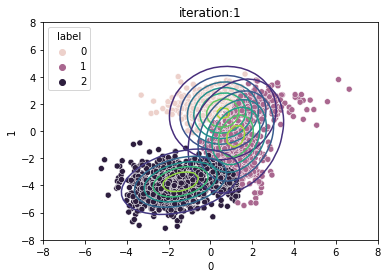

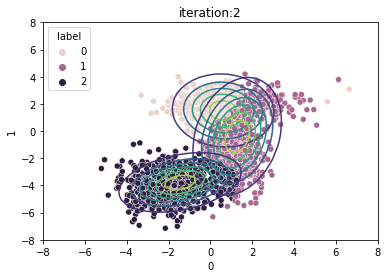

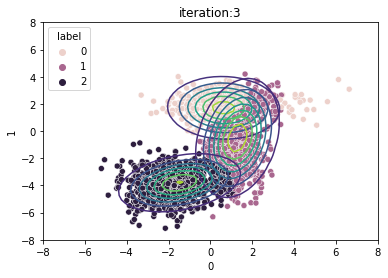

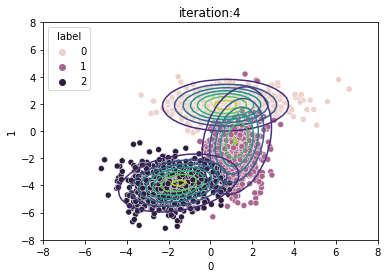

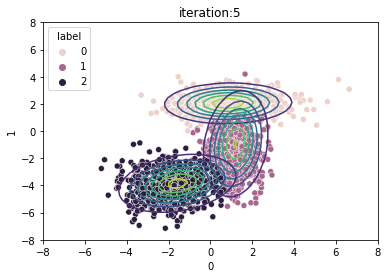

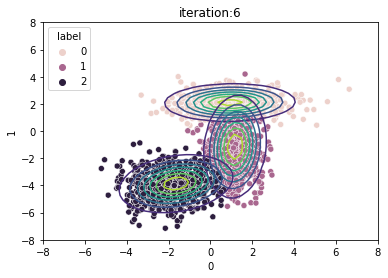

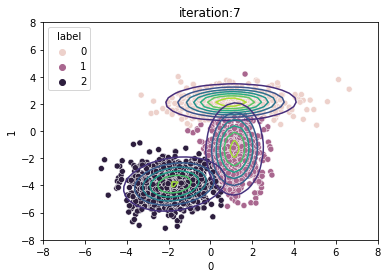

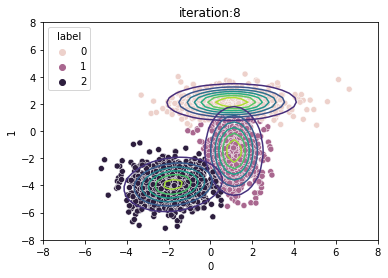

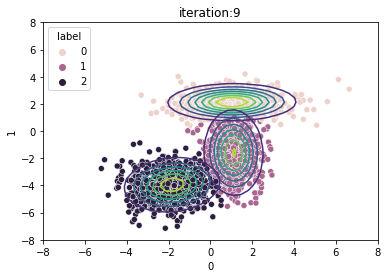

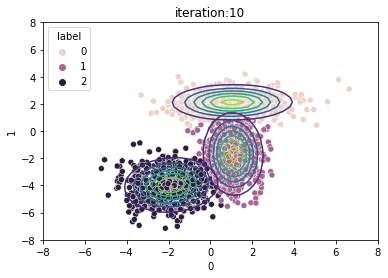

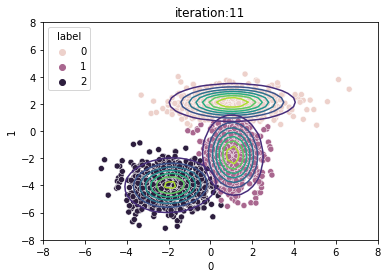

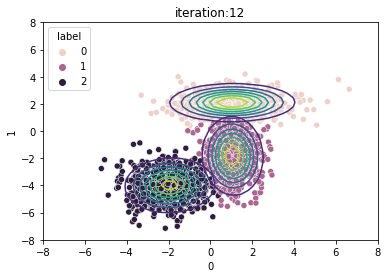

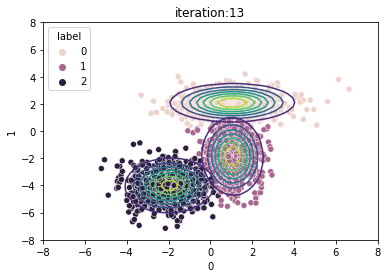

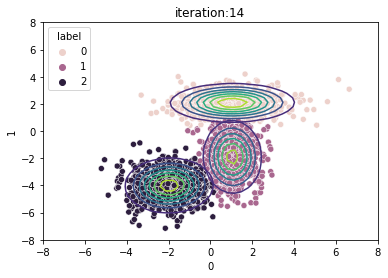

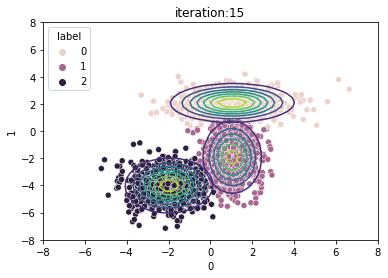

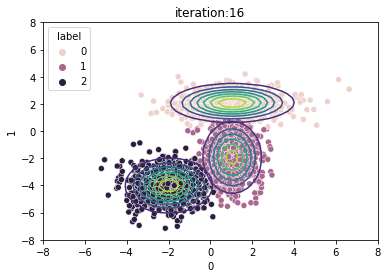

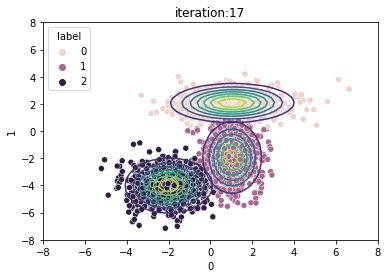

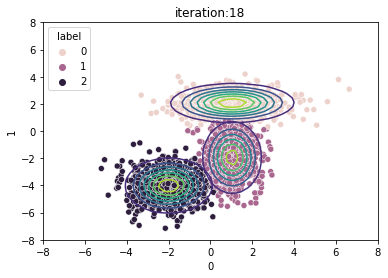

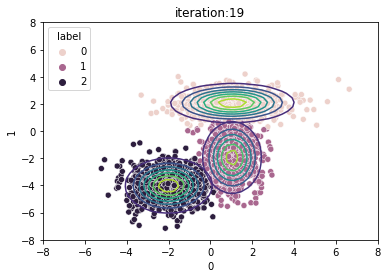

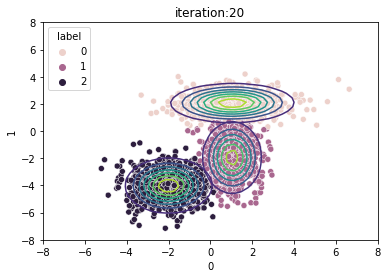

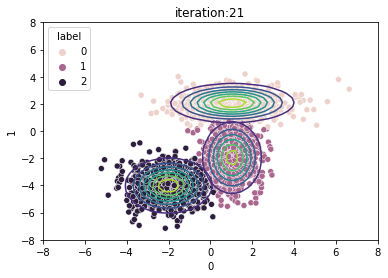

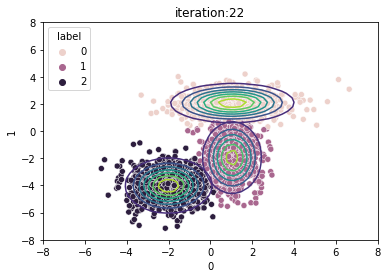

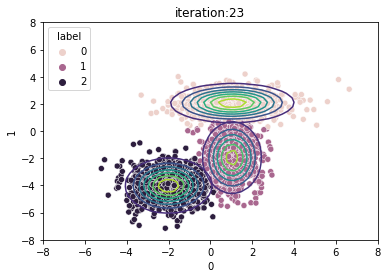

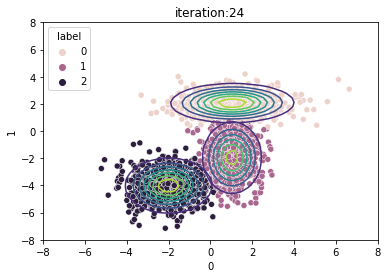

In [7]:
gmm = GaussianMixtureModel(3, max_iterations=100, TOL = 1e-3)
pi, mu, sigma, log_list, ite = gmm.fit(X)

Text(0.5, 0, 'Iteration')

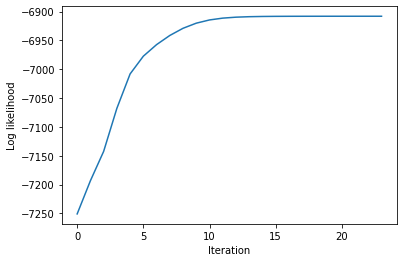

In [11]:
plt.plot([i for i in range(ite)],log_list)
plt.ylabel('Log likelihood')
plt.xlabel('Iteration')

In [12]:
print('pi:')
print(pi)
print()
print('mu:')
print(mu)
print()
print('sigma:')
print(sigma)
print()

pi:
[0.27429689 0.33523286 0.39047025]

mu:
[[ 1.0493593   2.06674537]
 [ 1.04150345 -1.95306806]
 [-1.99893231 -4.01394215]]

sigma:
[[[2.09875347 0.01470549]
  [0.01470549 0.49335662]]

 [[0.51172745 0.00390237]
  [0.00390237 1.84520711]]

 [[1.02504911 0.00466114]
  [0.00466114 0.98788654]]]



## 3. Determine the labels of each data using probability of each data: $P(x)$ (10 points)
### $[\pi_1 \mathcal{N}(x_i|\mu_1, \Sigma_1), \pi_2 \mathcal{N}(x_i|\mu_2, \Sigma_2), \pi_3 \mathcal{N}(x_i|\mu_3, \Sigma_3)]$

In [13]:
res = gmm.predict(X)

In [14]:
df = pd.DataFrame(X)
df['label']=res
df

,0,1,label
0,1.956278,2.094859,0
1,0.924220,2.538238,0
2,2.831249,2.346145,0
3,-1.543931,2.746824,0
4,1.859962,1.479576,0
...,...,...,...
1795,2.106026,-2.335066,1
1796,1.901406,-3.169427,1
1797,1.662917,-2.194019,1
1798,0.461823,-0.695171,1


## 4. Plot the results of three clusters (10 points)

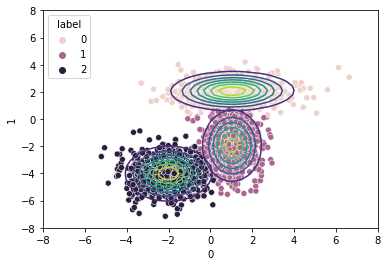

In [15]:
sns.scatterplot(data=df, x=df.iloc[:,0], y=df.iloc[:,1], hue="label")
for i in range(3):
    m = mu[i]  # defining the mean of the Gaussian (mX = 0.2, mY=0.6)
    cov = sigma[i]   # defining the covariance matrix
    cov_inv = np.linalg.inv(cov)  # inverse of covariance matrix
    cov_det = np.linalg.det(cov)  # determinant of covariance matrix
    # Plotting
    x = np.linspace(-8, 8)
    y = np.linspace(-8, 8)
    X,Y = np.meshgrid(x,y)
    coe = 1.0 / ((2 * np.pi)**2 * cov_det)**0.5
    Z = coe * np.e ** (-0.5 * (cov_inv[0,0]*(X-m[0])**2 + (cov_inv[0,1] + cov_inv[1,0])*(X-m[0])*(Y-m[1]) + cov_inv[1,1]*(Y-m[1])**2))
    plt.contour(X,Y,Z)



* Ref:  
1. https://brilliant.org/wiki/gaussian-mixture-model/
2. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html  
3. https://www.cs.toronto.edu/~urtasun/courses/CSC411_Fall16/13_mog.pdf  
4. https://stackoverflow.com/questions/28342968/how-to-plot-a-2d-gaussian-with-different-sigma